In [1]:
import os

# Read in all the captchas
images_folder = "images"
captchas = [
    os.path.join(images_folder, f) for f in os.listdir(images_folder)
]


In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

# Get the solution to the captcha via the filename
def get_CAPTCHA_label(captcha):
    filename = os.path.basename(captcha)
    label = filename.split(".")[0]
    return label

# Displays an image
def show(img):
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.show()
    
    
#=====================================================
# Helper functions to find contours of the characters
#=====================================================
    
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def threshold(grayscaled):
    return cv2.threshold(
       grayscaled, 140, 255, cv2.THRESH_BINARY_INV
    )[1]
   

def dilate_characters(thresholded):
    kernel = np.ones((2,2), np.uint8)
    return cv2.dilate(thresholded, kernel, iterations = 1)

def find_contours(dilated):
    return cv2.findContours(
        dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )[0]

#======================================================
# Helper functions to cut out the individual characters
#======================================================

def compute_bounding_rectangles(contours):
    return list(map(cv2.boundingRect, contours))

def show_bounding_rectangles(rectangles, img):
    img_tmp = img.copy()
    for rect in rectangles:
        x, y, w, h = rect
        cv2.rectangle(img_tmp, (x,y), (x+w, y+h), (255,0,0), 2)
    show(img_tmp)

# If the detected rectangles are too close together, they will be
# combined into one
def merge_rectangles(rectangles):
    # Combines two rectangles into one that encompasses both
    def merge(rect1, rect2):
        x1, y1, w1, h1 = rect1
        x2, y2, w2, h2 = rect2
        x = min(x1, x2)
        y = min(y1, y2)
        w = max(x1 + w1, x2 + w2) - x
        h = max(y1 + h1, y2 + h2) - y
        return (x, y, w, h)
    
    # Closeness according to x-axis
    def is_close(rect1, rect2):
        x1 = rect1[0]
        w1 = rect1[2]
        x2 = rect2[0]
        return abs(x1 - x2) <= 10 or abs(x1 + w1 - x2) <= 10
    
    # Rectangles should not be merged, if they are way above each other!
    # Closeness according to y-axis
    def way_above(rect1, rect2):
        x1 = rect1[0]
        x2 = rect2[0]
        y1 = rect1[1]
        y2 = rect2[1]
        w1 = rect1[2]
        h2 = rect2[3]
        return abs(y1 - y2) >= 20
        
    
    r = sorted(rectangles, key=lambda x: x[0]) # sort by x coordinate
    
    i = 0
    while (i < len(r) - 1):
        if is_close(r[i], r[i + 1]) and not way_above(r[1], r[i + 1]):
            r[i] = merge(r[i], r[i + 1])
            del r[i + 1]
        else:
            i += 1
            
    return r

# Cuts out the characters according to the bounding rectangles
def get_character_images(rectangles, image):
    char_images = []
    for rect in rectangles:
        x, y, w, h = rect
        char_image = image[y - 1 : y + h + 1, x - 1 : x + w + 1]
        char_images.append(char_image)
    return char_images


In [3]:
output_folder = "char_images"
character_counts = {}
skipped = 0
char_write_fails = 0

for img_file in captchas:
    label = get_CAPTCHA_label(img_file)
    
    # Determine contours
    img = cv2.imread(img_file)
    grayscaled = grayscale(img)
    thresholded = threshold(grayscaled)
    dilated = dilate_characters(thresholded)
    contours = find_contours(dilated)
    
    # Compute bounding rectangles
    rectangles = compute_bounding_rectangles(contours)
    rectangles = [rect for rect in rectangles if not (rect[2] <= 5 and rect[3] <=5)]
    rectangles = merge_rectangles(rectangles)
    
    # Cut out and save individual character images
    character_images = get_character_images(
        rectangles, dilated
    )
    
    for char_image, current_char in zip(character_images, label):
        if len(character_images) == 6:
            
            save_dir = os.path.join(output_folder, current_char)
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            character_count = character_counts.get(current_char, 1)
            image_save_path = os.path.join(save_dir, str(character_count) + ".png")
            try:
                cv2.imwrite(image_save_path, char_image)
            except:
                char_write_fails += 1
            character_counts[current_char] = character_count + 1
        
        else:
            skipped += 1
  


# How many captchas were skipped because not 6 characters were detected
print("Skipped:", skipped, "/", 6 * len(captchas))
# How many time a character was not written to a png file
print("Char write fails:", char_write_fails, "/", 6* len(captchas) - skipped)

Skipped: 27256 / 60000
Char write fails: 82 / 32744


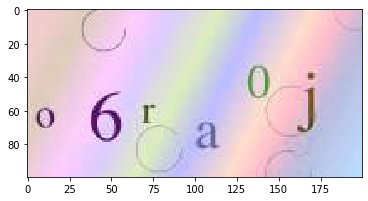

In [4]:
show(img)

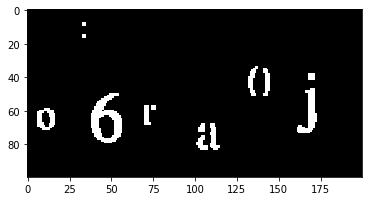

In [5]:
show(dilated)

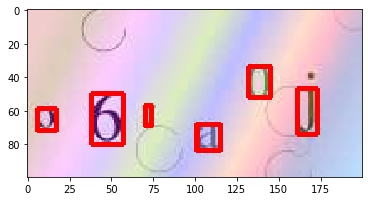

In [6]:
show_bounding_rectangles(rectangles, img)

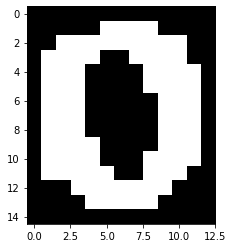

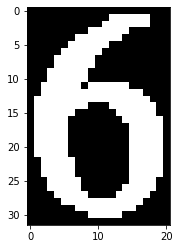

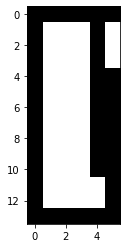

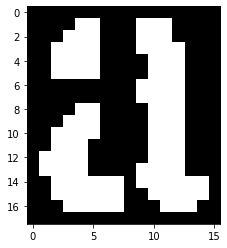

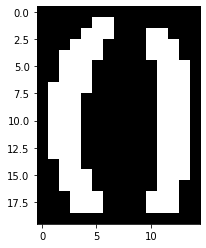

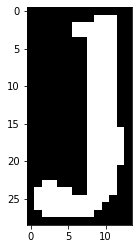

In [7]:
for character_image in character_images:
    show(character_image)